# DA-AG-003 — Practical Python: Error Handling, Logging, and Data Manipulation  
**Total Marks:** 200  

> This notebook contains detailed theory answers and runnable code cells for all questions.  
> Wherever the assignment asked for Seaborn plots, we include (a) a **Matplotlib** solution that works everywhere and  
> (b) an **optional Seaborn** snippet you can run if Seaborn is available in your environment.


## Question 1 : What is the difference between multithreading and multiprocessing?

### Answer
**Multithreading** and **multiprocessing** are both ways to achieve parallelism/concurrency, but they differ in how they use system resources and how they interact with Python’s runtime:

- **Execution model**
  - **Multithreading:** Multiple threads within a **single** process share the same memory space. Threads are lightweight, context switches are relatively cheap.
  - **Multiprocessing:** Multiple **processes** each with its **own** memory space. Processes are heavier, context switches are costlier, but they avoid many shared‑state issues.

- **Global Interpreter Lock (GIL) in CPython**
  - **Multithreading:** A single GIL means only one thread executes Python bytecode at a time. Threads are still very useful for **I/O‑bound** workloads (network calls, disk I/O) due to overlap of waiting time.
  - **Multiprocessing:** Each process has its own Python interpreter and GIL, so truly parallel **CPU‑bound** execution is possible across cores.

- **Memory and communication**
  - **Multithreading:** Shared memory by default; careful synchronization (locks, queues) is needed to avoid race conditions.
  - **Multiprocessing:** Memory is isolated. Data must be serialized (pickle) and passed via **Pipes/Queues/shared memory** → overhead but safer isolation.

- **Overheads & robustness**
  - **Multithreading:** Lower overhead, simpler startup, but tricky synchronization.
  - **Multiprocessing:** Higher startup/serialization overhead; more robust for CPU‑bound tasks and avoids GIL contention.

- **Rule of thumb**
  - For **I/O‑bound** work (web scraping, DB calls, logging, file transfers): use **threads**.
  - For **CPU‑bound** work (numerical computation, image processing, ML feature extraction): use **processes**.

**Real‑life examples**
- Threads: Handling thousands of concurrent HTTP requests where most time is waiting on network I/O.
- Processes: Running heavy image filters or matrix multiplications across CPU cores.


## Question 2: What are the challenges associated with memory management in Python?

### Answer
Key challenges include:

1. **Reference Counting & GC Nuances**
   - CPython uses **reference counting** plus a **cyclic garbage collector** (GC). Circular references (e.g., objects referencing each other) may delay reclamation until GC runs.
   - Objects with `__del__` (finalizers) in cycles can complicate collection.

2. **Copies vs. Views (Hidden memory bloat)**
   - Pandas and NumPy operations sometimes create **copies** when you expect a **view** (or vice‑versa). Unintended copies increase memory usage.

3. **Large Objects & Fragmentation**
   - Building very large lists/dicts or many small objects can cause memory fragmentation and high peak usage.

4. **Leaky Patterns**
   - Long‑lived globals/caches, unbounded lists, storing entire data files in memory, or holding references in closures cause memory to “leak” logically (even if not technically).

5. **Interfacing with Native Extensions**
   - C/C++ extensions (NumPy, OpenCV, etc.) allocate memory outside Python’s heap. Misuse or forgetting to free buffers can cause high RSS.

6. **Data Types & Precision**
   - Using higher‑precision dtypes than needed (e.g., `float64` instead of `float32`) doubles memory without benefit.

7. **Monitoring is non‑trivial**
   - Measuring Python vs. OS RSS, separating Python heap from native allocations, and profiling per‑object usage requires tools (e.g., `tracemalloc`, `psutil`, memory profilers).

**Mitigations**
- Prefer vectorized NumPy/Pandas operations; be mindful of copies (`.copy()`) and in‑place ops.
- Use appropriate dtypes, chunked processing, streaming, generators.
- Clear references (`del`, reassign to `None`), scope variables tightly, use LRU caches with bounds.
- Profile memory with `tracemalloc`, `memory_profiler`, or `psutil`.


## Question 3: Write a Python program that logs an error message to a log file when a division by zero exception occurs.

### Answer
The following example uses Python’s built‑in `logging` module. It logs to a file (`app.log`) and includes the exception stack trace.


In [1]:
import logging

# Configure logging to write to a file with timestamp and level
logging.basicConfig(
    filename='app.log',
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def safe_divide(a, b):
    try:
        return a / b
    except ZeroDivisionError as e:
        logging.exception("Attempted division by zero: a=%s, b=%s", a, b)
        return None

# Example usage
result = safe_divide(10, 0)
print("Result:", result)
print("If you run this cell, check 'app.log' in the working directory for the logged error.")


Result: None
If you run this cell, check 'app.log' in the working directory for the logged error.


## Question 4: Write a Python program that reads from one file and writes its content to another file.

### Answer
The snippet below safely reads from a source file and writes to a destination file using context managers.  
It creates a demo source file first to keep the example self‑contained.


In [2]:
from pathlib import Path

# Create a demo source file
src = Path('demo_source.txt')
dst = Path('demo_copy.txt')
src.write_text('Hello! This is a demo file.\nIt has multiple lines.\nEnjoy!\n', encoding='utf-8')

# Copy: read then write
with src.open('r', encoding='utf-8') as fin, dst.open('w', encoding='utf-8') as fout:
    for line in fin:
        fout.write(line)

print(f"Copied {src} -> {dst}")
print(dst.read_text(encoding='utf-8'))


Copied demo_source.txt -> demo_copy.txt
Hello! This is a demo file.
It has multiple lines.
Enjoy!



## Question 5: Write a program that handles both IndexError and KeyError using a try-except block.

### Answer
The following code shows both errors handled gracefully and reports which one occurred.


In [3]:
def access_items(seq, mapping):
    try:
        # Intentionally access an out-of-range index and a missing key
        _ = seq[10]           # may raise IndexError
        _ = mapping['missing']  # may raise KeyError
        return "Both accesses succeeded."
    except IndexError as e:
        return f"Caught IndexError: {e}"
    except KeyError as e:
        return f"Caught KeyError: {e}"

print(access_items([1,2,3], {'a': 1, 'b': 2}))


Caught IndexError: list index out of range


## Question 6: What are the differences between NumPy arrays and Python lists?

### Answer
- **Homogeneity vs. Heterogeneity**
  - **NumPy arrays** are typically homogeneous (single dtype), enabling compact memory layout and SIMD‑friendly operations.
  - **Python lists** can hold mixed types; flexible but slower for numerical work.

- **Vectorization & Broadcasting**
  - NumPy supports vectorized operations (element‑wise arithmetic) and **broadcasting**, avoiding Python loops.
  - Lists require explicit loops or comprehensions for element‑wise math.

- **Performance & Memory**
  - NumPy arrays are faster and more memory‑efficient for large numeric workloads.
  - Lists have pointer indirection and per‑element overhead.

- **APIs & Functionality**
  - NumPy provides rich numerical routines (linear algebra, FFTs, random sampling).
  - Lists are general containers with limited math operations.

**Example**


In [4]:
import numpy as np
nums = np.array([1, 2, 3, 4], dtype=np.int32)
lst  = [1, 2, 3, 4]

print("Vectorized add (NumPy):", nums + 10)  # element-wise
# The next line would error for lists: # lst + 10
print("List comprehension:", [x + 10 for x in lst])


Vectorized add (NumPy): [11 12 13 14]
List comprehension: [11, 12, 13, 14]


## Question 7: Explain the difference between `apply()` and `map()` in Pandas.

### Answer
- **`Series.map(func or dict)`**
  - Works on a **Series** only.
  - Element‑wise transformation or value mapping using a function or a dict.
  - Great for lookups and simple element transforms.

- **`Series.apply(func)`**
  - Also works on a **Series**; calls `func` on each element. Slightly more general than `map`.

- **`DataFrame.apply(func, axis=0/1)`**
  - Operates across **rows** (`axis=1`) or **columns** (`axis=0`).
  - `func` gets a Series representing each row/column; useful for row/column reductions or derived features.
  - Slower than vectorized methods; prefer vectorization when possible.

**Example**


In [5]:
import pandas as pd

df = pd.DataFrame({
    'name': ['alice', 'bob', 'carol'],
    'math': [80, 75, 90],
    'eng':  [85, 88, 92]
})

# Series.map with dict (value mapping)
grade_map = {80: 'B', 75: 'C', 90: 'A'}
df['math_letter'] = df['math'].map(grade_map)

# Series.apply with a function (element-wise)
df['name_title'] = df['name'].apply(str.title)

# DataFrame.apply across rows to compute total
df['total'] = df.apply(lambda r: r['math'] + r['eng'], axis=1)

df


,name,math,eng,math_letter,name_title,total
0,alice,80,85,B,Alice,165
1,bob,75,88,C,Bob,163
2,carol,90,92,A,Carol,182


## Question 8: Create a histogram using Seaborn to visualize a distribution.

### Answer
Below are **two** approaches:
1. **Matplotlib** (works everywhere and does not require Seaborn)
2. **Optional Seaborn** version (uncomment/install Seaborn to run)

We simulate a real‑life example: test scores for 200 students.


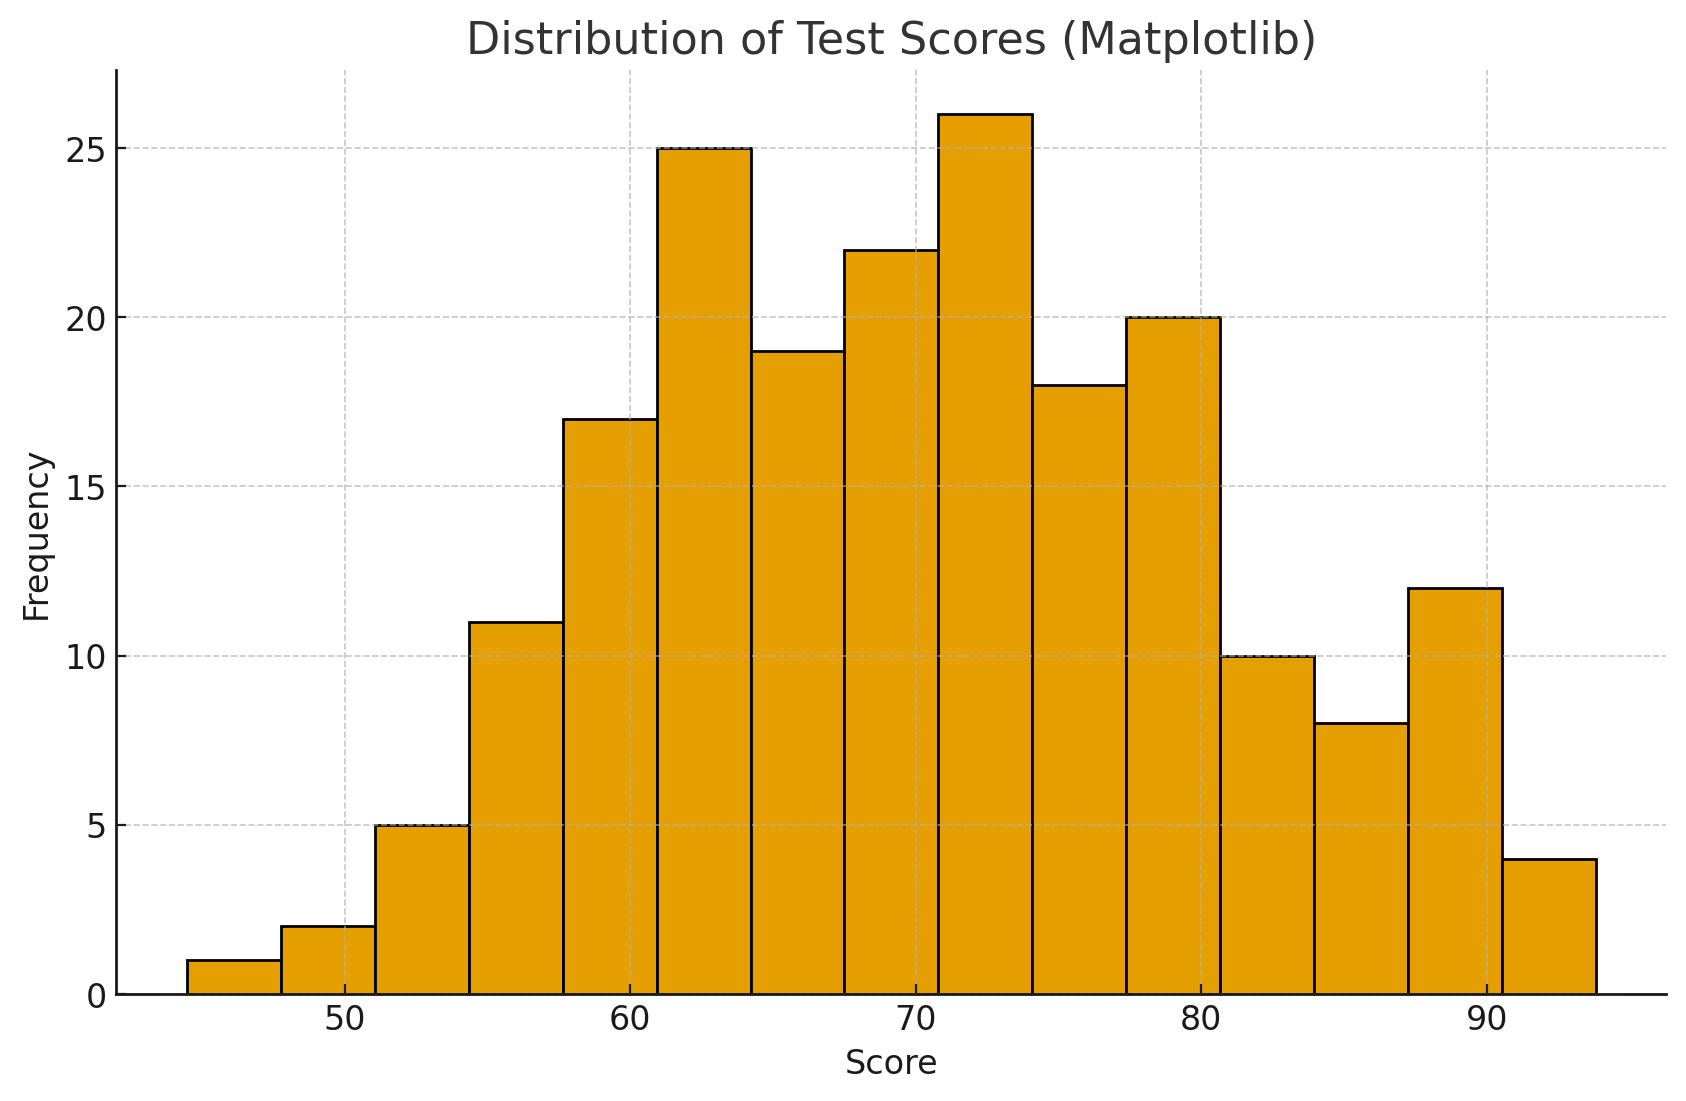

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
scores = np.clip(np.random.normal(loc=70, scale=10, size=200), 0, 100)

plt.figure()
plt.hist(scores, bins=15, edgecolor='black')
plt.title('Distribution of Test Scores (Matplotlib)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Optional: Seaborn version (requires seaborn)
# import seaborn as sns
# import numpy as np
# np.random.seed(0)
# scores = np.clip(np.random.normal(loc=70, scale=10, size=200), 0, 100)
# sns.histplot(scores, bins=15, kde=True)
# import matplotlib.pyplot as plt
# plt.title('Distribution of Test Scores (Seaborn)')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.show()


## Question 9: Use Pandas to load a CSV file and display its first 5 rows.

### Answer
This cell **creates** a small CSV file (to keep the notebook self‑contained), then reads it with Pandas and shows `.head(5)`.


In [8]:
import pandas as pd

# Create a sample CSV
sample = pd.DataFrame({
    'id': [1,2,3,4,5,6,7],
    'age': [22, 25, 31, 45, 29, 34, 27],
    'income': [35_000, 42_500, 58_000, 76_000, 49_000, 63_000, 40_000]
})
sample.to_csv('people.csv', index=False)

# Load and display first 5 rows
df = pd.read_csv('people.csv')
df.head(5)


,id,age,income
0,1,22,35000
1,2,25,42500
2,3,31,58000
3,4,45,76000
4,5,29,49000


## Question 10: Calculate the correlation matrix using Seaborn and visualize it with a heatmap.

### Answer
We compute a correlation matrix with Pandas, then show two plotting options:
1. **Matplotlib** (works everywhere)
2. **Optional Seaborn** (uncomment if Seaborn is available)

**Real‑life context:** Correlations among financial indicators (e.g., income, expenses, savings). Here we use synthetic data.


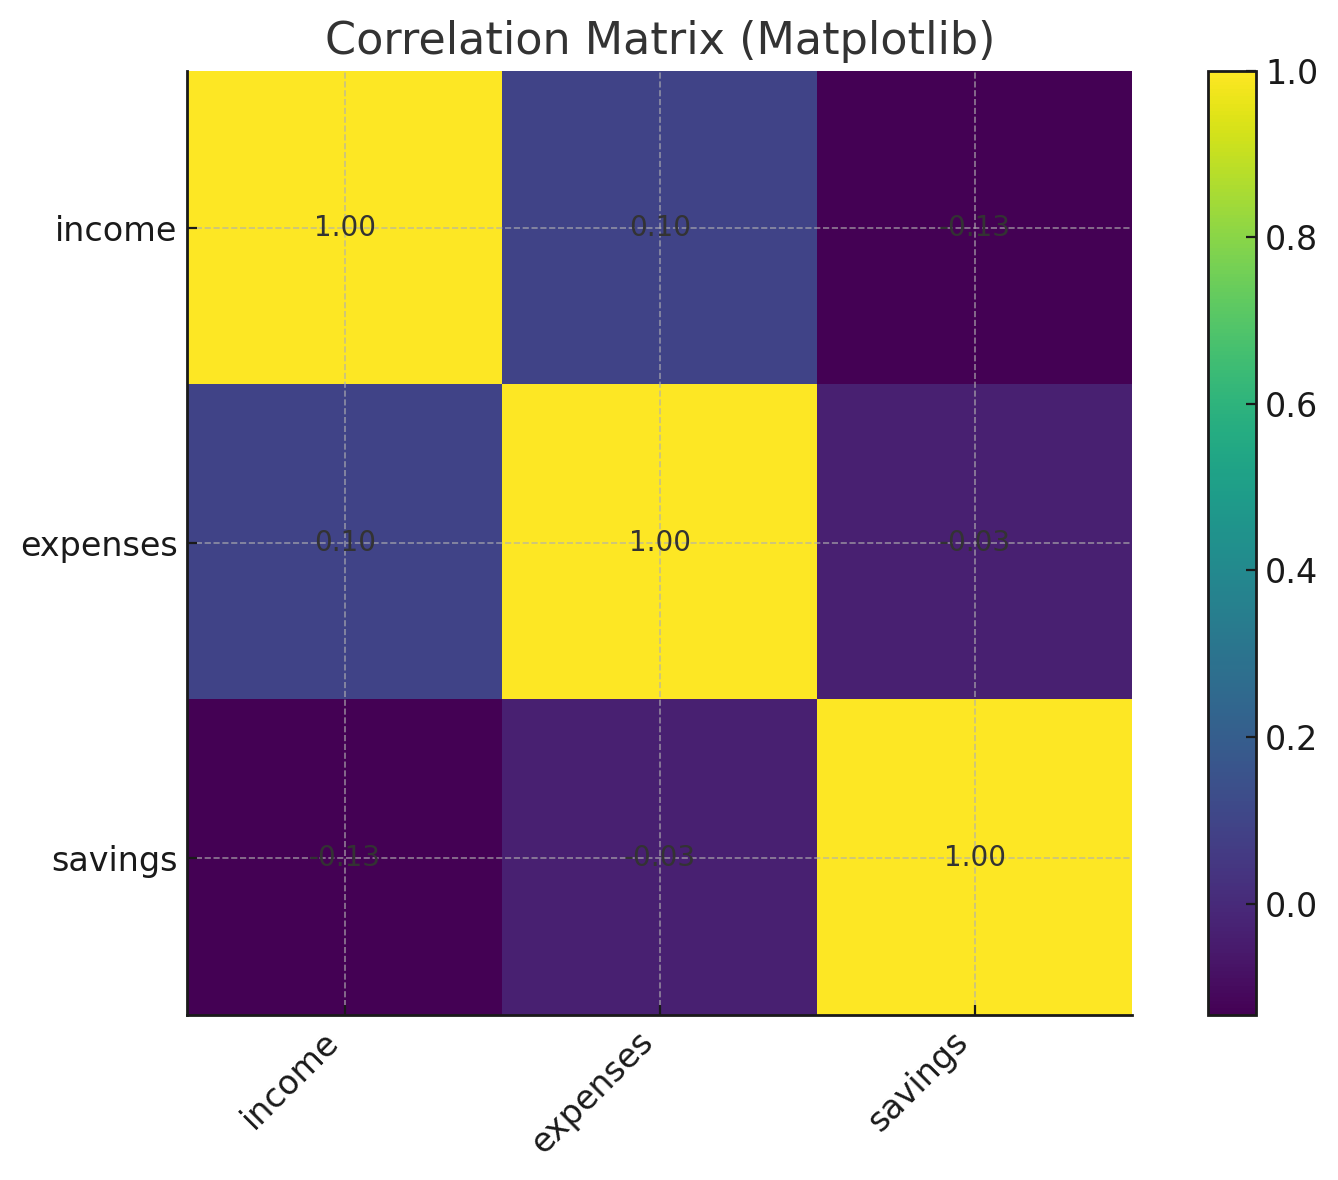

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 200
data = pd.DataFrame({
    'income':   np.random.normal(60_000, 10_000, size=n),
    'expenses': np.random.normal(35_000,  7_000, size=n),
    'savings':  np.random.normal(10_000,  5_000, size=n),
})

corr = data.corr(numeric_only=True)

plt.figure()
im = plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Matrix (Matplotlib)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(im, fraction=0.046, pad=0.04)

# Annotate cells
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center')

plt.tight_layout()
plt.show()


In [10]:
# Optional: Seaborn version (requires seaborn)
# import seaborn as sns
# import pandas as pd
# import numpy as np
# np.random.seed(42)
# n = 200
# data = pd.DataFrame({
#     'income':   np.random.normal(60_000, 10_000, size=n),
#     'expenses': np.random.normal(35_000,  7_000, size=n),
#     'savings':  np.random.normal(10_000,  5_000, size=n),
# })
# corr = data.corr(numeric_only=True)
# ax = sns.heatmap(corr, annot=True, fmt='.2f')
# ax.set_title('Correlation Matrix (Seaborn)')
# import matplotlib.pyplot as plt
# plt.show()
